In [1]:
import numpy as np
import random as rand
import networkx as nx
import time
import matplotlib.pyplot as plt

In [2]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import dwave_networkx as dnx

In [3]:
def randomGraph(num_vertices,density=1,seed=None):
    scale = np.sqrt(num_vertices)/density
    if seed is not None:
        rand.seed(seed)
    graph = [(rand.random()*scale,rand.random()*scale) for n in range(num_vertices)]
    return graph

In [41]:
class GraphClass():
    def __init__(self, graph):
        self.graph = graph
        self.num_vertices = len(self.graph)
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def to_nx(self):
        I,J = np.where(np.triu(self.edges))
        G  = nx.Graph()
        G.add_edges_from(list(zip(I,J)))
        return G   
    
    def find_edges(self):
        G = np.array(self.graph)
        D = np.sqrt(np.square(G[:,0:1]-np.transpose(G[:,0:1])) + np.square(G[:,1:2]-np.transpose(G[:,1:2])))
        edges = (D<1)*(D!=0)
        return edges     
    
    def draw_graph(self,occupations = None):
        
        # inner function
        def draw_circles(ax,xs,ys,cs):

            # plot the non activated vertices in the background
            for x,y,c in zip(xs,ys,cs):
                if not(c):
                    circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
                    ax.add_patch(circle)

            # plot the activated vertices in the foreground        
            for x,y,c in zip(xs,ys,cs):
                if c:
                    circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
                    ax.add_patch(circle)
        
        #core of function
        graph_np = np.array(self.graph)
        xs = graph_np[:,0]
        ys = graph_np[:,1]
        
        if occupations==None:
            cs = self.occupations
            fig, ax = plt.subplots()
            draw_circles(ax,xs,ys,cs)
            ax.axis('equal')
        else:
            N = min(5,len(occupations))
            fig, axs = plt.subplots(1,N,figsize=(20,4))
            for i in range(N):
                cs = occupations[i]
                draw_circles(axs[i],xs,ys,cs)
                axs[i].axis('equal')
        
        return fig
        
    def brute_force(self):
        num_vertices = self.num_vertices
        format_string = '0' + str(num_vertices) + 'b'
        bitlist = []
        for n in range(2**num_vertices):
            bitlist.append([int(x) for x in format(n, format_string)])
        A = np.array(bitlist)
        I,J = np.where(np.triu(self.edges))
        edge = np.zeros(2**num_vertices)
        for i,j in zip(I,J):
            edge += A[:,i]*A[:,j]
        cost = np.sum(A,axis=1)*1.0 - edge * num_vertices
        energy = np.max(cost)
        solutions = A[cost==energy,:]
        occupations = (solutions == 1).tolist()
        return energy,occupations
    
    def quantum_annealing(self,simulated=True):
        if simulated == True:
            sampler = dimod.SimulatedAnnealingSampler()
        else:
            sampler = EmbeddingComposite(DWaveSampler())
        G_nx = self.to_nx()

        indep_nodes = dnx.maximum_independent_set(G_nx, sampler)

        occupations = np.full(self.num_vertices, False, dtype=bool)
        occupations[indep_nodes] = True
        
        energy = np.sum(occupations)
        
        return energy,occupations

In [112]:
class Benchmark():
    def __init__(self, num_vertices = [5,10,20],num_sample = 20):
        self.num_vertices = num_vertices
        self.num_sample = num_sample
        self.energies = np.zeros((3,len(num_vertices),num_sample))
        self.times = np.zeros((3,len(num_vertices),num_sample))
        
    def benchmark_time(self,keep_occupations=False):
        
        if keep_occupations:
            occupations_b = []
        for n,num_vertice in enumerate(self.num_vertices):
            occupations_n = []
            for s in range(self.num_sample):
                occupations_s = []
                
                #init graph
                graph = randomGraph(num_vertice)
                graph_c = GraphClass(graph)
                
                #brute force
                tic = time.time()
                energy,occupations = graph_c.brute_force()
                toc = time.time()
                self.energies[0,n,s] = energy
                self.times[0,n,s] = toc-tic
                if keep_occupations:
                    graph_c.occupations = occupations[0]
                    graph_c.draw_graph()
                    print(energy)
#                     occupations_s.append(list(occupations))
                
                #simulated quantum annealing
                tic = time.time()
                energy,occupations = graph_c.quantum_annealing()
                toc = time.time()
                self.energies[1,n,s] = energy
                self.times[1,n,s] = toc-tic
                if keep_occupations:
                    graph_c.occupations = occupations
                    graph_c.draw_graph()
                    print(energy)
#                     occupations_s.append(list(occupations))
                
#                 #real quantum annealing
#                 tic = time.time()
#                 energy,occupations = graph_c.quantum_annealing(simulated=False)
#                 toc = time.time()
#                 self.energies[2,n,s] = energy
#                 self.times[2,n,s] = toc-tic
#                 if keep_occupations:
#                     graph_c.occupations = occupations
#                     graph_c.draw_graph()
#                     occupations_s.append(list(occupations))
                if keep_occupations:
                    occupations_n.append(occupations_s)
            if keep_occupations:
                occupations_b.append(occupations_n)
                self.occupations_b = occupations_b
    def plot_scatter_benchmark(self):
        num_vertices_plot = np.repeat(np.array(self.num_vertices),self.num_sample)
        
        #plot simulated
        diff_energy = self.energies[0]-self.energies[1]
        diff_log_time = np.log(self.times[1]/self.times[0])
        
        plt.scatter(num_vertices_plot,diff_log_time.flatten(),c=diff_energy.flatten())
        plt.xlabel('number of vertices')
        plt.ylabel('log time difference')
        plt.title('simulated quantum annealing, color is the energy loss')
        plt.colorbar()
    def plot_benchmark(self):
        mean_energy_loss = np.mean(bench.energies[0]-bench.energies[1],axis=1)
        mean_log_time_diff = np.log(np.mean(bench.times[1]/bench.times[0],axis=1))
        num_vertices_plot = np.array(self.num_vertices)
        plt.scatter(mean_energy_loss,mean_log_time_diff,c=num_vertices_plot)
        plt.xlabel('energy loss')
        plt.ylabel('log time difference')
        plt.title('simulated quantum annealing, color is the number of vertices')
        plt.colorbar()
        

In [108]:
bench = Benchmark([10,11],num_sample=20)

In [109]:
bench.benchmark_time()
# bench.benchmark_time(keep_occupations=True)

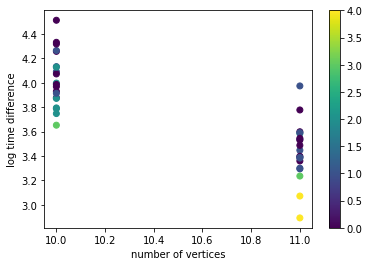

In [111]:
bench.plot_scatter_benchmark()

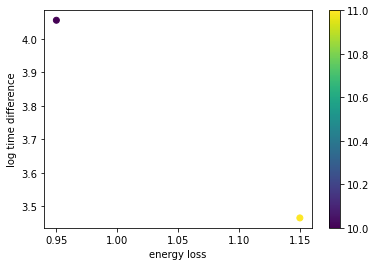

In [110]:
bench.plot_benchmark()

In [114]:
bench = Benchmark(list(range(10,24,3)),num_sample=10)

In [115]:
bench.benchmark_time()

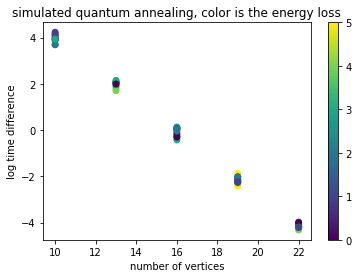

In [116]:
bench.plot_scatter_benchmark()

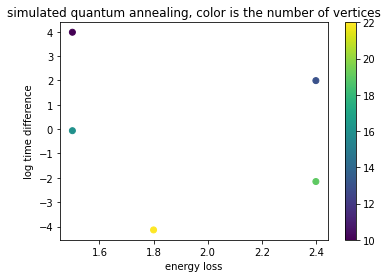

In [117]:
bench.plot_benchmark()